# 💀 Bone Fracture Multi-Region X-ray

이 데이터셋은 하지, 상지, 요추, 엉덩이, 무릎 등 모든 해부학적 신체 부위를 포함하는 골절 및 비골절 X-레이 이미지를 포함하고 있습니다. 

데이터 출처 : https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/data


In [9]:
# import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from IPython.display import display


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import torch
from torch import nn #모델 정의
import torch.nn.functional as F #모델 정의
from torch.utils.data import TensorDataset, DataLoader #데이터로드
from sklearn.preprocessing import LabelEncoder
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim # 옵티마이저
from sklearn.metrics import precision_score, recall_score, f1_score

## 데이터 사전 정리

In [10]:
# 파일명 정리
def chage_name(folder_path, name_code, start_numder = 1):
    name_list = [file for file in os.listdir(folder_path) if file.endswith((".png",".jpg",".jpeg"))]
    digit = len(str(len(name_list))) + 1
    for idex, file in enumerate(name_list):
        numder = digit - len(str(idex))
        position = file.rfind(".")
        following_text = file[position:]

        old_file_path = os.path.join(folder_path, file)
        new_file_name = name_code + "0" * numder + str(idex + start_numder) + following_text
        new_file_path = os.path.join(folder_path, new_file_name)
        os.rename(old_file_path, new_file_path)

    updated_files = os.listdir(folder_path)
    print(updated_files)

In [11]:
# 파일 확정자 변경
def change_file_determiner(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".png") or filename.endswith(".bmp"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            # 팔레트 모드(P)에서 RGB로 변환
            if img.mode == 'P':
                img = img.convert('RGB')
            # RGBA를 RGB로 변환, 필요한 경우
            elif img.mode == 'RGBA':
                img = img.convert('RGB')
            new_filename = filename.split('.')[0] + '.jpeg'
            new_img_path = os.path.join(directory, new_filename)
            img.save(new_img_path, 'JPEG')
            os.remove(img_path)  # 원본 파일 삭제

In [12]:
# F_name = "BXF_TR_"
# image_path_fractured = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/train/fractured"

# N_name = "BXN_TR_"
# image_path_No = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/train/not fractured"

# change_file_determiner(image_path_fractured)
# chage_name(image_path_fractured,F_name,0)
# change_file_determiner(image_path_No)
# chage_name(image_path_No,N_name,0)


# F_name = "BXF_VA_"
# image_path_fractured = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/val/fractured"

# N_name = "BXN_VA_"
# image_path_No = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/val/not fractured"

# change_file_determiner(image_path_fractured)
# chage_name(image_path_fractured,F_name,0)
# change_file_determiner(image_path_No)
# chage_name(image_path_No,N_name,0)

# F_name = "BXF_TE_"
# image_path_fractured = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/fractured"

# N_name = "BXN_TE_"
# image_path_No = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/not fractured"

# change_file_determiner(image_path_fractured)
# chage_name(image_path_fractured,F_name,0)
# change_file_determiner(image_path_No)
# chage_name(image_path_No,N_name,0)

In [13]:
data_dir = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data"
data = os.listdir(data_dir)
len(data)

3

In [14]:
def data_image_len(dir):
    data = os.listdir(dir)
    return len(data)

In [15]:
BB_test_fr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/fractured"
BB_test_nfr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/not fractured"
BB_train_fr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/train/fractured"
BB_train_nfr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/train/not fractured"
BB_val_fr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/val/fractured"
BB_val_nfr = "/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/val/not fractured"

data_dir_list = [BB_test_fr,BB_test_nfr,BB_train_fr,BB_train_nfr,BB_val_fr,BB_val_nfr]

totel = 0
for i in data_dir_list:
    totel += data_image_len(i)
    print(data_image_len(i))
print(totel)

238
268
4604
4640
337
492
10579


In [16]:
def show_random_images(image_path):
    # 이미지 파일 확장자 리스트
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    
    # 주어진 경로에서 모든 파일을 리스트업
    all_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
    
    # 이미지 파일만 필터링
    image_files = [f for f in all_files if os.path.splitext(f)[1].lower() in valid_extensions]
    
    # 이미지 파일이 9개 미만일 경우 모든 이미지를 보여줌
    if len(image_files) < 9:
        selected_images = image_files
    else:
        # 무작위로 9개의 이미지 파일 선택
        selected_images = random.sample(image_files, 9)
    
    # 선택된 이미지 파일을 출력
    for image_file in selected_images:
        image = Image.open(image_file)
        display(image)

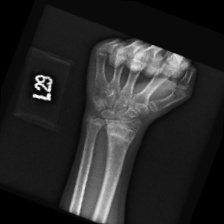

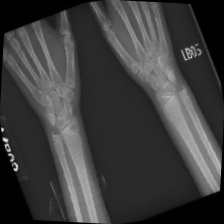

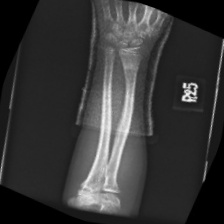

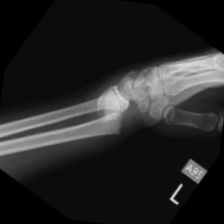

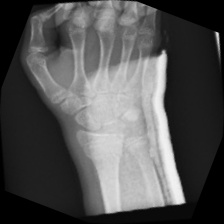

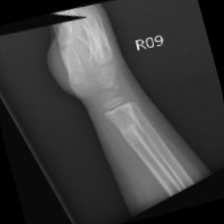

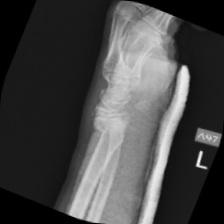

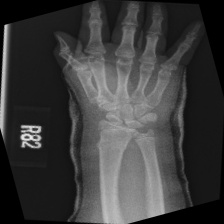

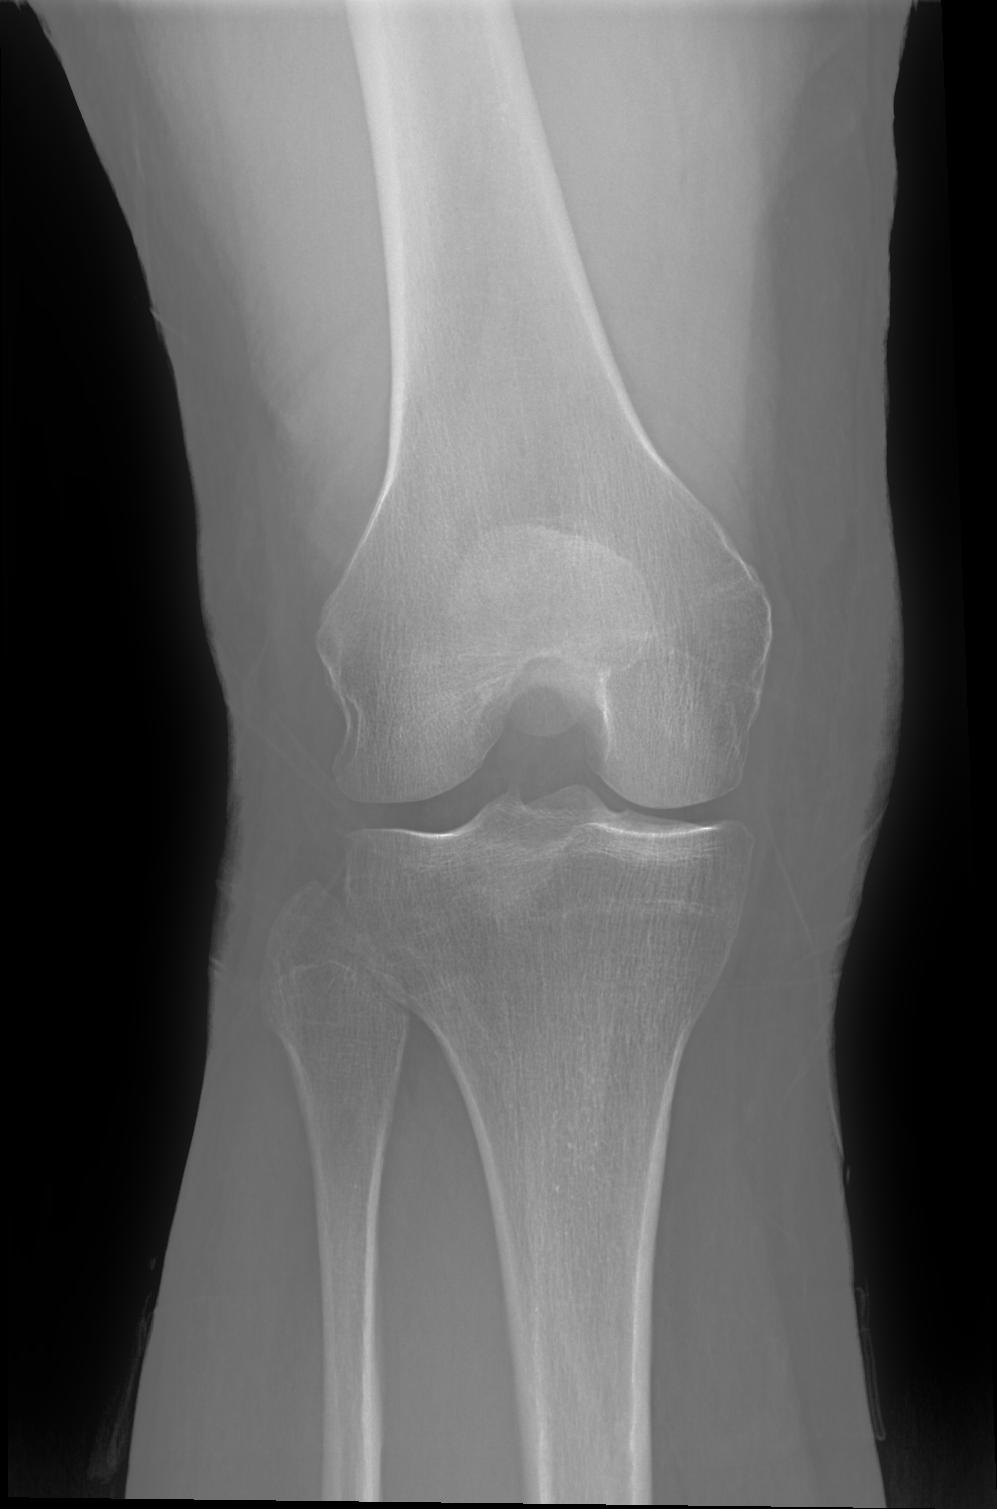

In [17]:
show_random_images(BB_test_fr)

In [18]:
def get_image_size(image_path):
    # 이미지 파일 열기
    with Image.open(image_path) as img:
        # 이미지의 크기를 반환
        return img.size  # (width, height)

In [19]:
image_size = get_image_size('/Users/bumsoojoe/Desktop/Project/Bone Fracture DL/Data/Bone_Fracture_Binary_Classification/test/fractured/BXF_TE_0000.jpg')
print(f'Image size: {image_size[0]} x {image_size[1]} pixels')  # 가로 x 세로 픽셀로 출력

Image size: 224 x 224 pixels


In [20]:
name_list = [file for file in os.listdir(BB_test_fr) if file.endswith((".png",".jpg",".jpeg"))]
name_list

['BXF_TE_0132.jpg',
 'BXF_TE_0126.jpg',
 'BXF_TE_0068.jpeg',
 'BXF_TE_0085.jpg',
 'BXF_TE_0091.jpg',
 'BXF_TE_0046.jpg',
 'BXF_TE_0052.jpg',
 'BXF_TE_0053.jpg',
 'BXF_TE_0047.jpg',
 'BXF_TE_0005.jpeg',
 'BXF_TE_0090.jpg',
 'BXF_TE_0084.jpg',
 'BXF_TE_0101.jpeg',
 'BXF_TE_0133.jpg',
 'BXF_TE_0125.jpg',
 'BXF_TE_0131.jpg',
 'BXF_TE_0208.jpeg',
 'BXF_TE_0119.jpg',
 'BXF_TE_0160.jpeg',
 'BXF_TE_0092.jpg',
 'BXF_TE_0086.jpg',
 'BXF_TE_0051.jpg',
 'BXF_TE_0045.jpg',
 'BXF_TE_0078.jpg',
 'BXF_TE_0044.jpg',
 'BXF_TE_0050.jpg',
 'BXF_TE_0087.jpg',
 'BXF_TE_0118.jpg',
 'BXF_TE_0130.jpg',
 'BXF_TE_0124.jpg',
 'BXF_TE_0108.jpg',
 'BXF_TE_0134.jpg',
 'BXF_TE_0049.jpeg',
 'BXF_TE_0097.jpg',
 'BXF_TE_0083.jpg',
 'BXF_TE_0054.jpg',
 'BXF_TE_0041.jpg',
 'BXF_TE_0055.jpg',
 'BXF_TE_0069.jpg',
 'BXF_TE_0082.jpg',
 'BXF_TE_0136.jpeg',
 'BXF_TE_0024.jpeg',
 'BXF_TE_0135.jpg',
 'BXF_TE_0121.jpg',
 'BXF_TE_0109.jpg',
 'BXF_TE_0120.jpeg',
 'BXF_TE_0157.jpeg',
 'BXF_TE_0137.jpg',
 'BXF_TE_0043.jpg',
 'BXF_TE_0

In [21]:
name_list = []

for i in data_dir_list:
    name_list.extend([file for file in os.listdir(i) if file.endswith((".png",".jpg",".jpeg"))])


In [22]:
df = pd.DataFrame()

In [23]:
df["Image_name"] = name_list

In [24]:
df

,Image_name
0,BXF_TE_0132.jpg
1,BXF_TE_0126.jpg
2,BXF_TE_0068.jpeg
3,BXF_TE_0085.jpg
4,BXF_TE_0091.jpg
...,...
10574,BXN_VA_0325.jpg
10575,BXN_VA_0443.jpg
10576,BXN_VA_0457.jpg
10577,BXN_VA_0331.jpg


In [25]:
def Image_sizes(name,wh): #(width : 0 , height : 1)
    names = name.split("_")
    if names[1] == "TE" and "F" in names[0]:
        pro_dir = BB_test_fr
    elif names[1] == "TE" and "N" in names[0]:
        pro_dir = BB_test_nfr
    elif names[1] == "TR" and "F" in names[0]:
        pro_dir = BB_train_fr
    elif names[1] == "TR" and "N" in names[0]:
        pro_dir = BB_train_nfr
    elif names[1] == "VA" and "F" in names[0]:
        pro_dir = BB_val_fr
    else:
        pro_dir = BB_val_nfr

    dir = pro_dir + "/" + name
    image_size = get_image_size(dir)
    return image_size[wh]


In [28]:
Image_sizes("BXN_VA_0480.jpg",0)

373

In [32]:
df["width"] = df.Image_name.apply(lambda x : Image_sizes(x,0))
df["height"] = df.Image_name.apply(lambda x : Image_sizes(x,1))
df

,Image_name,width,height
0,BXF_TE_0132.jpg,224,224
1,BXF_TE_0126.jpg,224,224
2,BXF_TE_0068.jpeg,846,1498
3,BXF_TE_0085.jpg,224,224
4,BXF_TE_0091.jpg,224,224
...,...,...,...
10574,BXN_VA_0325.jpg,224,224
10575,BXN_VA_0443.jpg,224,224
10576,BXN_VA_0457.jpg,224,224
10577,BXN_VA_0331.jpg,224,224


In [38]:
print(f'Image Min size: {min(df["width"])} x {min(df["height"])} pixels')
print(f'Image Max size: {max(df["width"])} x {max(df["height"])} pixels')
print(f'Image Mean size: {df["width"].mean().round(2)} x {df["height"].mean().round(2)} pixels')
# 모든 이미지 사이즈를 100 x 100으로 축소해야한다.

Image Min size: 100 x 100 pixels
Image Max size: 4232 x 5823 pixels
Image Mean size: 299.7 x 325.03 pixels


In [ ]:
def 